# Cylinder Annihilation Demo

In this demo, we use the constructive solid geometry (CSG) method to create a spatial domain in the shape of a cylinder. The cylinder has it's long dimension (x-axis) from -5 to 5, the circular dimension has diameter of 1.  The chemical species 'A' is created at one end, and species 'B' is created at the other.  They diffuse through the volume of the cylinder and annihilate in the reaction A + B -> EmptySet.  This example shows how to create domains with CSG, how to define subdomains, and how to create zero-th order and bimolecular reactions.  It also provides a test for the software as the expected result is gradient of A and B, high as the ends and vanishing at the mid-point.

In [1]:
# Import libraries to be used later
%matplotlib inline
import matplotlib.pyplot as plt
import sys,os
import numpy
import pyurdme
import dolfin
import mshr
from IPython.display import clear_output

## Define the Cylinder Annihilation model 

In [2]:
class RightEdge(dolfin.SubDomain): # Define the right subdomain
    def inside(self, x, on_boundary):
        return on_boundary and x[0] > 4.9
class LeftEdge(dolfin.SubDomain): # Define the left subdomain
    def inside(self, x, on_boundary):
        return on_boundary and x[0] < -4.9

In [3]:
class CylinderDemo(pyurdme.URDMEModel):
    def __init__(self, model_name="CylinderDemo"):
        pyurdme.URDMEModel.__init__(self, model_name)
        # Define Species
        A = pyurdme.Species(name="A", diffusion_constant=1.0)
        B = pyurdme.Species(name="B", diffusion_constant=1.0)
        self.add_species([A, B])
        # Define Geometry
        cylinder = mshr.Cylinder(dolfin.Point(5, 0, 0), dolfin.Point(-5, 0, 0), 1.0, 1.0)
        self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(cylinder, 32))
        # Define Subdomains
        self.add_subdomain(RightEdge(), 2)
        self.add_subdomain(LeftEdge(), 3)
        # Define Parameters
        k_react = pyurdme.Parameter(name="k_react", expression=1.0)
        k_create = pyurdme.Parameter(name="k_create", expression=100)
        self.add_parameter([k_react, k_create])
        # Define Reactions
        R1 = pyurdme.Reaction(name="R1",reactants=None, products={A:1}, rate=k_create, restrict_to=2)
        R2 = pyurdme.Reaction(name="R2",reactants=None, products={B:1}, rate=k_create, restrict_to=3)
        R3 = pyurdme.Reaction(name="R3",reactants={A:1, B:1}, products=None, rate=k_react)
        self.add_reaction([R1, R2, R3])
        # Define simulation timespan
        self.timespan(range(200))

## Run the model and plot the results

In [4]:
model = CylinderDemo()
%time result = model.run()

CPU times: user 3.49 s, sys: 8.12 ms, total: 3.5 s
Wall time: 7.93 s


In [5]:
# Uncomment the line below the see the 3D visualization of 'B' at t=100 
result.display('B', 100, wireframe=False)

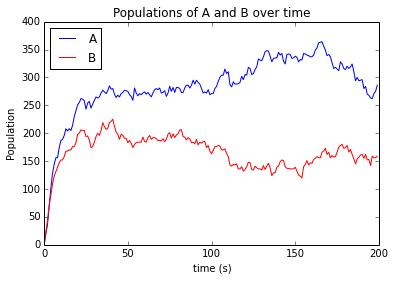

In [6]:
plt.plot(numpy.sum(result.get_species('A'), axis=1),'-b',numpy.sum(result.get_species('B'), axis=1),'-r')
plt.title('Populations of A and B over time')
plt.xlabel('time (s)')
plt.ylabel('Population')
plt.legend(['A','B'], loc='best')

The plot above shows the mis-match in the creation rates of 'A' and 'B'.  This is due to the CSG mesh not giving the same number of voxels to the left and right subdomains.

In [7]:
data = model.get_solver_datastructure()
vol = data['vol']
sd = data['sd']
print "Number of voxels left {0}, right {1}, center {2} subdomains".format(numpy.sum(sd == 2), numpy.sum(sd == 3), numpy.sum(sd == 1))

Number of voxels left 19, right 20, center 1033 subdomains


## Define the Corrected Cylinder Annihilation model 

In [10]:
class cylinderDemo3D(pyurdme.URDMEModel):
    def __init__(self, model_name="cylinder_demo3d"):
        pyurdme.URDMEModel.__init__(self, model_name)
        # Define Species
        A = pyurdme.Species(name="A", diffusion_constant=1.0)
        B = pyurdme.Species(name="B", diffusion_constant=1.0)
        self.add_species([A, B])
        # Define Geometry
        #cylinder = dolfin.Cylinder(dolfin.Point(5, 0, 0), dolfin.Point(-5, 0, 0), 1.0)
        cylinder = mshr.Cylinder(dolfin.Point(5, 0, 0), dolfin.Point(-5, 0, 0), 1.0, 1.0)
        self.mesh = pyurdme.URDMEMesh(mesh=mshr.generate_mesh(cylinder, 32))
        # Define Subdomains
        self.add_subdomain(RightEdge(), 2)
        self.add_subdomain(LeftEdge(), 3)
        # This section is a fix to ensure the creation rates are equal.  Since
        # The creation reactions are zero-th order, They are proportional to volume.
        # Due to the discritization the sum volume of the voxels in subdomain 1 may
        # not be the same as the sum volume of the voxels in subdomain 2.  We adjust 
        # the parameters so that the net creation rate the same for both. 
        data = self.get_solver_datastructure()
        vol = data['vol']
        sd = data['sd']
        right = numpy.sum(vol[sd == 2])
        left = numpy.sum(vol[sd == 3])
        print "Total Subdomain Volume: Right(A)={0} Left(B)={1}".format(left, right)
        # Define Parameters
        k_react = pyurdme.Parameter(name="k_react", expression=1.0)
        k_creat1 = pyurdme.Parameter(name="k_creat1", expression=100/left)
        k_creat2 = pyurdme.Parameter(name="k_creat2", expression=100/right)
        print "Net create rate: A={0} B={1}".format(100/left, 100/right)        
        self.add_parameter([k_react, k_creat1, k_creat2])
        # Define Reactions
        R1 = pyurdme.Reaction(name="R1", reactants=None, products={A:1}, rate=k_creat1, restrict_to=2)
        R2 = pyurdme.Reaction(name="R2", reactants=None, products={B:1}, rate=k_creat2, restrict_to=3)
        R3 = pyurdme.Reaction(name="R3", reactants={A:1, B:1}, products=None, rate=k_react)
        self.add_reaction([R1, R2, R3])
        # Define simulation timespan
        self.timespan(range(200))

In [11]:
%time model = cylinderDemo3D()

Total Subdomain Volume: Right(A)=0.285002606889 Left(B)=0.288423433689
Net create rate: A=350.873983546 B=346.712466185
CPU times: user 6.62 s, sys: 112 ms, total: 6.73 s
Wall time: 6.72 s


## Simulate the System

In [12]:
%time result = model.run()

CPU times: user 3.32 s, sys: 8.01 ms, total: 3.33 s
Wall time: 22 s


## Visualization of the Results

In [13]:
model.mesh

In [14]:
result.display('A', 199, wireframe=False)

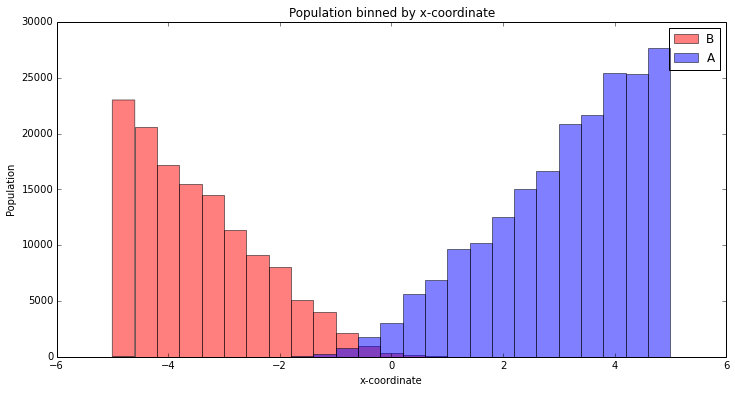

In [15]:
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False), axis=0)
plt.figure(figsize=(12,6), dpi=100)
num_bins = 25
plt.hist(x_vals, bins=num_bins, weights=B_vals, facecolor='red', alpha=0.5)
plt.hist(x_vals, bins=num_bins, weights=A_vals, facecolor='blue', alpha=0.5)
plt.legend(['B','A'])
plt.xlabel('x-coordinate')
plt.ylabel('Population')
plt.title('Population binned by x-coordinate')

## Animated Plot of the concentration of A and B over time

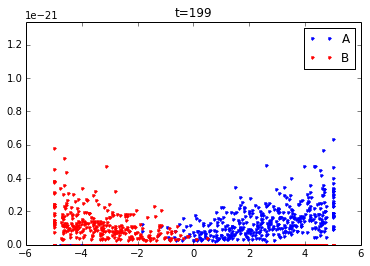

In [16]:
x_vals = model.mesh.coordinates()[:,0]
A_vals = result.get_species('A', concentration=True)
B_vals = result.get_species('B', concentration=True)
maxval = max(numpy.max(A_vals), numpy.max(B_vals))
for tndx, tval in enumerate(model.tspan):
    plt.plot(x_vals, A_vals[tndx,:],'.b', x_vals, B_vals[tndx,:],'.r')
    plt.axis([-6, 6, 0, maxval])
    plt.legend(['A','B'])
    plt.title('t={0}'.format(tval))
    clear_output(wait=True)
    plt.show()